In [1]:
'''
统一设置地址
'''

import os

# 获取当前工作目录
current_dir = os.getcwd()
print("当前工作目录：", current_dir)

# 修改当前工作目录，以后输出文件只需要写文件名
new_dir = "D:/李娅宁/肩台外侧点-0715/"
os.chdir(new_dir)
print("修改后的工作目录：", os.getcwd())


当前工作目录： C:\Users\HP
修改后的工作目录： D:\李娅宁\肩台外侧点-0715


In [2]:
'''
3D FCN
'''

'\n3D FCN\n'

Epoch 1/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 410s 4s/step - accuracy: 0.8396 - loss: 0.6006 - val_accuracy: 0.8903 - val_loss: 0.3191 - learning_rate: 2.0000e-05
Epoch 2/2
69/69 ━━━━━━━━━━━━━━━━━━━━ 271s 4s/step - accuracy: 0.8897 - loss: 0.2938 - val_accuracy: 0.9199 - val_loss: 0.1644 - learning_rate: 2.0000e-05
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9159 - loss: 0.1726
Test Loss: 0.17399942874908447
Test Accuracy: 0.9147135615348816


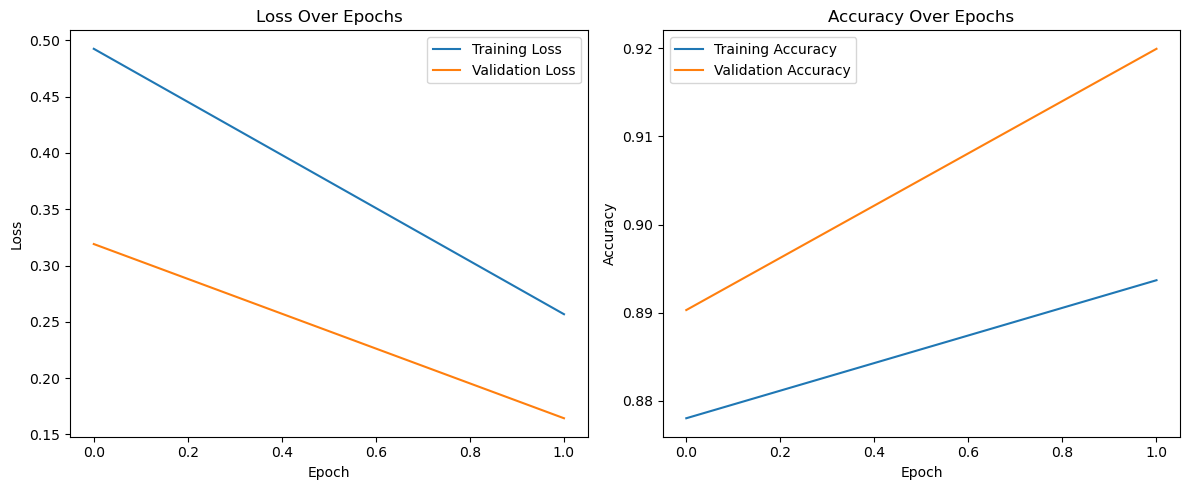

Model saved to July27模型/FCN_3D_softmax.h5


In [3]:
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 读取点云数据和标签
def load_labeled_point_cloud(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 4:
                x, y, z, label = map(float, parts)
                data.append([x, y, z])
                labels.append(int(label))
    return np.array(data), np.array(labels)

def create_voxel_grid(data, labels, grid_size):
    if data.size == 0 or labels.size == 0:
        print(f"Warning: Empty data or labels array. data.size={data.size}, labels.size={labels.size}")
        return None, None

    grid = np.zeros((grid_size, grid_size, grid_size))
    label_grid = np.zeros((grid_size, grid_size, grid_size))

    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1
        label_grid[voxel[0], voxel[1], voxel[2]] = labels[i] - 1  # Convert labels 1 and 2 to 0 and 1

    return grid, label_grid

def load_data_from_directory(data_dir, grid_size=16):
    x_data = []
    y_data = []
    for file in os.listdir(data_dir):
        if file.endswith("_labeled.txt"):
            file_path = os.path.join(data_dir, file)
            data, labels = load_labeled_point_cloud(file_path)
            if data.size == 0 or labels.size == 0:
                print(f"Skipping empty file: {file_path}")
                continue
            voxel_grid, label_grid = create_voxel_grid(data, labels, grid_size)
            if voxel_grid is not None and label_grid is not None:
                # 应用数据增强
                voxel_grid = augment_voxel_grid(voxel_grid)
                x_data.append(voxel_grid)
                y_data.append(label_grid)
    x_data = np.expand_dims(np.array(x_data), axis=-1)
    y_data = np.expand_dims(np.array(y_data), axis=-1)
    return x_data, y_data

# 数据增强
def augment_voxel_grid(voxel_grid):
    """
    对体素网格进行随机旋转和翻转。
    """
    # 随机旋转
    angle = np.random.uniform(0, 360)
    voxel_grid = np.rot90(voxel_grid, k=int(angle // 90), axes=(0, 1))
    
    # 随机翻转
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=0)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=1)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=2)
    
    return voxel_grid

# 定义3D FCN模型
def fcn_3d(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    # Bottleneck
    conv5 = tf.keras.layers.Conv3D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv3D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = tf.keras.layers.Conv3DTranspose(512, 2, strides=(2, 2, 2), padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([up6, conv4], axis=-1)
    conv6 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same')(concat6)
    conv6 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv3], axis=-1)
    conv7 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same')(concat7)
    conv7 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv7)
    concat8 = tf.keras.layers.concatenate([up8, conv2], axis=-1)
    conv8 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same')(concat8)
    conv8 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(conv8)
    concat9 = tf.keras.layers.concatenate([up9, conv1], axis=-1)
    conv9 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same')(concat9)
    conv9 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same')(conv9)

    # 输出层
    outputs = tf.keras.layers.Conv3D(num_classes, 1, activation='softmax')(conv9)  # num_classes channel output for multi-class classification

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

# 定义学习率调度函数
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.2).numpy())

# 加载数据
data_dir = '重新处理后的数据_手工筛选'
x_data, y_data = load_data_from_directory(data_dir, grid_size=16)

# 确保数据归一化
x_data = x_data / np.max(x_data)

# 由于 y_data 的标签是类别索引，保证 y_data 为整数形式
y_data = y_data.astype(np.int32)

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

# 定义模型
input_shape = (16, 16, 16, 1)
num_classes = 2  # 设定你的类别数量
model = fcn_3d(input_shape, num_classes)

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002), 
              loss='sparse_categorical_crossentropy',  # 使用多类别交叉熵损失
              metrics=['accuracy'])

# 定义学习率调度回调和早停回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(
    x_train, y_train, 
    validation_split=0.1,
    epochs=2, 
    batch_size=10,
    callbacks=[lr_scheduler, early_stopping]
)

# 评估模型
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 绘制训练过程中的损失和精确度
def plot_training_history(history):
    """
    绘制训练过程中的损失和精确度。
    """
    # 绘制损失
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # 绘制精确度
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 绘制训练历史
plot_training_history(history)

# 保存模型
model_save_path = 'July27模型/FCN_3D_softmax.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


In [ ]:
'''
3D Mask RCNN
'''

In [2]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 读取点云数据和标签
def load_labeled_point_cloud(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 4:
                x, y, z, label = map(float, parts)
                data.append([x, y, z])
                labels.append(int(label))
    return np.array(data), np.array(labels)

def create_voxel_grid(data, labels, grid_size):
    if data.size == 0 or labels.size == 0:
        print(f"Warning: Empty data or labels array. data.size={data.size}, labels.size={labels.size}")
        return None, None

    grid = np.zeros((grid_size, grid_size, grid_size))
    label_grid = np.zeros((grid_size, grid_size, grid_size))

    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1
        label_grid[voxel[0], voxel[1], voxel[2]] = labels[i] - 1  # Convert labels 1 and 2 to 0 and 1

    return grid, label_grid

def load_data_from_directory(data_dir, grid_size=16):
    x_data = []
    y_data = []
    for file in os.listdir(data_dir):
        if file.endswith("_labeled.txt"):
            file_path = os.path.join(data_dir, file)
            data, labels = load_labeled_point_cloud(file_path)
            if data.size == 0 or labels.size == 0:
                print(f"Skipping empty file: {file_path}")
                continue
            voxel_grid, label_grid = create_voxel_grid(data, labels, grid_size)
            if voxel_grid is not None and label_grid is not None:
                # 应用数据增强
                voxel_grid = augment_voxel_grid(voxel_grid)
                x_data.append(voxel_grid)
                y_data.append(label_grid)
    x_data = np.expand_dims(np.array(x_data), axis=-1)
    y_data = np.expand_dims(np.array(y_data), axis=-1)
    return x_data, y_data

# 数据增强
def augment_voxel_grid(voxel_grid):
    """
    对体素网格进行随机旋转和翻转。
    """
    # 随机旋转
    angle = np.random.uniform(0, 360)
    voxel_grid = np.rot90(voxel_grid, k=int(angle // 90), axes=(0, 1))
    
    # 随机翻转
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=0)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=1)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=2)
    
    return voxel_grid

# 定义区域提议网络（RPN）
def rpn_layer(base_layers, anchors_per_location, anchor_stride):
    shared = tf.keras.layers.Conv3D(512, (3, 3, 3), padding='same', activation='relu', strides=anchor_stride)(base_layers)

    x = tf.keras.layers.Conv3D(2 * anchors_per_location, (1, 1, 1), padding='valid', activation='linear')(shared)
    rpn_class_logits = tf.keras.layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 2]))(x)

    rpn_probs = tf.keras.layers.Activation("softmax")(rpn_class_logits)

    x = tf.keras.layers.Conv3D(anchors_per_location * 6, (1, 1, 1), padding='valid', activation='linear')(shared)
    rpn_bbox = tf.keras.layers.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 6]))(x)

    return [rpn_class_logits, rpn_probs, rpn_bbox]

# 定义ROI Align层
def roi_align_layer(inputs, pool_size, image_shape):
    # Placeholder for actual ROI Align logic
    return tf.image.resize(inputs, pool_size)

# 3D Mask R-CNN模型定义
def mask_rcnn_3d(input_shape, num_classes, anchors_per_location=9, anchor_stride=1, pool_size=(7, 7)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # 使用预训练的ResNet50作为骨干网络
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights=None)
    base_layers = base_model(inputs)

    # 区域提议网络（RPN）
    rpn_class_logits, rpn_probs, rpn_bbox = rpn_layer(base_layers, anchors_per_location, anchor_stride)

    # ROI Align
    rois = roi_align_layer(rpn_bbox, pool_size, input_shape)

    # 分类头
    cls_head = tf.keras.layers.Dense(1024, activation='relu')(rois)
    cls_head = tf.keras.layers.Dense(1024, activation='relu')(cls_head)
    cls_out = tf.keras.layers.Dense(num_classes, activation='softmax')(cls_head)

    # 边界框回归头
    reg_head = tf.keras.layers.Dense(1024, activation='relu')(rois)
    reg_head = tf.keras.layers.Dense(1024, activation='relu')(reg_head)
    reg_out = tf.keras.layers.Dense(num_classes * 6)(reg_head)

    # 掩码头
    mask_conv1 = tf.keras.layers.Conv3D(256, (3, 3, 3), padding='same', activation='relu')(rois)
    mask_conv2 = tf.keras.layers.Conv3D(256, (3, 3, 3), padding='same', activation='relu')(mask_conv1)
    mask_out = tf.keras.layers.Conv3D(num_classes, (1, 1, 1), activation='softmax')(mask_conv2)

    model = tf.keras.models.Model(inputs=inputs, outputs=[cls_out, reg_out, mask_out])
    return model

# 定义学习率调度函数
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.2).numpy())

# 加载数据
data_dir = '重新处理后的数据_手工筛选'
x_data, y_data = load_data_from_directory(data_dir, grid_size=16)

# 确保数据归一化
x_data = x_data / np.max(x_data)

# 由于 y_data 的标签是类别索引，保证 y_data 为整数形式
y_data = y_data.astype(np.int32)

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

# 定义模型
input_shape = (16, 16, 16, 1)
num_classes = 2  # 设定你的类别数量
model = mask_rcnn_3d(input_shape, num_classes)

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002), 
              loss=['sparse_categorical_crossentropy', 'mse', 'sparse_categorical_crossentropy'],  # 损失函数
              metrics=['accuracy'])

# 定义学习率调度回调和早停回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(
    x_train, [y_train, y_train, y_train],  # 使用多个输出
    validation_split=0.1,
    epochs=2, 
    batch_size=10,
    callbacks=[lr_scheduler, early_stopping]
)

# 评估模型
test_loss, test_accuracy = model.evaluate(x_test, [y_test, y_test, y_test])

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 绘制训练过程中的损失和精确度
def plot_training_history(history):
    """
    绘制训练过程中的损失和精确度。
    """
    # 绘制损失
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # 绘制精确度
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 绘制训练历史
plot_training_history(history)

# 保存模型
model_save_path = 'July27模型/Mask_RCNN_3D_softmax.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


D:\Anaconda\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
D:\Anaconda\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.17.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and su

ModuleNotFoundError: No module named 'keras.src.engine'

In [ ]:
'''
3D DenseNET
'''

In [6]:
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 读取点云数据和标签
def load_labeled_point_cloud(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 4:
                x, y, z, label = map(float, parts)
                data.append([x, y, z])
                labels.append(int(label))
    return np.array(data), np.array(labels)

def create_voxel_grid(data, labels, grid_size):
    if data.size == 0 or labels.size == 0:
        print(f"Warning: Empty data or labels array. data.size={data.size}, labels.size={labels.size}")
        return None, None

    grid = np.zeros((grid_size, grid_size, grid_size))
    label_grid = np.zeros((grid_size, grid_size, grid_size))

    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1
        label_grid[voxel[0], voxel[1], voxel[2]] = labels[i] - 1  # Convert labels 1 and 2 to 0 and 1

    return grid, label_grid

def load_data_from_directory(data_dir, grid_size=16):
    x_data = []
    y_data = []
    for file in os.listdir(data_dir):
        if file.endswith("_labeled.txt"):
            file_path = os.path.join(data_dir, file)
            data, labels = load_labeled_point_cloud(file_path)
            if data.size == 0 or labels.size == 0:
                print(f"Skipping empty file: {file_path}")
                continue
            voxel_grid, label_grid = create_voxel_grid(data, labels, grid_size)
            if voxel_grid is not None and label_grid is not None:
                # 应用数据增强
                voxel_grid = augment_voxel_grid(voxel_grid)
                x_data.append(voxel_grid)
                y_data.append(label_grid)
    x_data = np.expand_dims(np.array(x_data), axis=-1)
    y_data = np.array(y_data)
    return x_data, y_data

# 数据增强
def augment_voxel_grid(voxel_grid):
    """
    对体素网格进行随机旋转和翻转。
    """
    # 随机旋转
    angle = np.random.uniform(0, 360)
    voxel_grid = np.rot90(voxel_grid, k=int(angle // 90), axes=(0, 1))
    
    # 随机翻转
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=0)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=1)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=2)
    
    return voxel_grid

# 定义DenseNet的Dense块
def dense_block(x, filters, name):
    for i in range(4):
        y = tf.keras.layers.BatchNormalization()(x)
        y = tf.keras.layers.ReLU()(y)
        y = tf.keras.layers.Conv3D(filters, (3, 3, 3), padding='same')(y)
        x = tf.keras.layers.concatenate([x, y])
    return x

# 定义DenseNet的过渡层
def transition_layer(x, filters, name):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv3D(filters, (1, 1, 1), padding='same')(x)
    x = tf.keras.layers.AveragePooling3D((2, 2, 2), strides=(2, 2, 2))(x)
    return x

# 定义3D DenseNet模型
def densenet_3d(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv3D(64, (3, 3, 3), padding='same')(inputs)
    x = dense_block(x, 64, name='dense_block_1')
    x = transition_layer(x, 128, name='trans_layer_1')
    x = dense_block(x, 128, name='dense_block_2')
    x = transition_layer(x, 256, name='trans_layer_2')
    x = dense_block(x, 256, name='dense_block_3')
    x = transition_layer(x, 512, name='trans_layer_3')
    x = dense_block(x, 512, name='dense_block_4')
    
    x = tf.keras.layers.Conv3D(num_classes, (1, 1, 1), padding='same')(x)
    outputs = tf.keras.layers.Softmax(axis=-1)(x)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model


# 定义学习率调度函数
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.2).numpy())

# 加载数据
data_dir = '重新处理后的数据_手工筛选'
x_data, y_data = load_data_from_directory(data_dir, grid_size=16)

# 确保数据归一化
x_data = x_data / np.max(x_data)

# 由于 y_data 的标签是类别索引，保证 y_data 为整数形式
y_data = y_data.astype(np.int32)

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

# 定义模型
input_shape = (16, 16, 16, 1)
num_classes = 2  # 设定你的类别数量
model = densenet_3d(input_shape, num_classes)

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00002), 
              loss='sparse_categorical_crossentropy',  # 使用多类别交叉熵损失
              metrics=['accuracy'])

# 定义学习率调度回调和早停回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(
    x_train, y_train, 
    validation_split=0.1,
    epochs=2, 
    batch_size=10,
    callbacks=[lr_scheduler, early_stopping]
)

# 评估模型
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 绘制训练过程中的损失和精确度
def plot_training_history(history):
    """
    绘制训练过程中的损失和精确度。
    """
    # 绘制损失
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # 绘制精确度
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 绘制训练历史
plot_training_history(history)

# 保存模型
model_save_path = 'July27模型/DenseNet_3D_softmax.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Epoch 1/2


ValueError: Arguments `target` and `output` must have the same shape up until the last dimension: target.shape=(None, 16, 16, 16), output.shape=(None, 2, 2, 2, 2)